先import一些library

In [1]:
import datetime
import os
import time
import warnings
import gc
# import presets
import torch
import torch.utils.data
import torchvision
from tmp_modules import utils,transforms

# from coco_utils import get_coco
from torch import nn
from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import functional as F, InterpolationMode
import torchvision.transforms as transforms
try:
    from pytorch_model_summary import summary
except:
    !pip install pytorch-model-summary
    from pytorch_model_summary import summary

try:
    from torchviz import make_dot
except:
    !pip install torchviz
    from torchviz import make_dot

import transformers
try:
    import datasets
except:
    !pip install cchardet
    !pip install datasets
    import datasets
    
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from IPython.display import clear_output, display

try:
        from thop import profile
except:
        !pip install thop

import torch
from transformers import SamModel, SamProcessor

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


先定義一些function

In [2]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    """
    print("student_outputs size = ", student_outputs["out"].size())
    print("student_outputs = ", student_outputs["out"])
    print("teacher_outputs size = ", teacher_outputs[0].size())
    print("teacher_outputs = ", teacher_outputs[0])
    """
    # Calculate Cross Entropy
    original_loss = nn.functional.cross_entropy(student_outputs["out"], labels, ignore_index=255)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0][0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs["out"][0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # 總損失為原始損失加上蒸餾損失
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss

    return total_loss

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    model.to(device)

    header = "Test:"
    num_processed_samples = 0
    total_loss            = 0
    with torch.inference_mode():
        for image, target in data_loader:
            image, target = image.to(device), target.to(device)

            ###
            target = target.squeeze(1)
            # Convert target to Long type
            target = target.type(torch.LongTensor).to(device)
            
            output = model(image)
            loss = criterion(output, target)
            total_loss += loss.item()
            # output = output["out"]
            # confmat.update(target.flatten(), output.argmax(1).flatten())
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            num_processed_samples += image.shape[0]
            
            del image, target, output, loss

            gc.collect()
            torch.cuda.empty_cache()
    return total_loss/ num_processed_samples

# 用enumerate去iterate through all the data.
def train_one_epoch_01(student_model, teacher_model, processor, criterion, teacher_ratio, temperature, optimizer, data_loader, lr_scheduler, device, pbar, scaler=None):
    student_model.train()
    teacher_model.eval()
    training_loss = []
    for idx, (image, target) in enumerate(data_loader):
        bbox = [[[get_bounding_box(np.array(target))]]] # 先用 target 找出 bounding box 的座標

        image, target = image.to(device), target.to(device)
        ### ground truth given by annotation
        target = target.squeeze(1)
        # Convert target to Long type
        target = target.type(torch.LongTensor).to(device)
        ############################################################### Teacher Model : SAM
        # Retrieve the image embeddings
        # processor
        inputs = processor(image, return_tensors="pt").to(device)
        image_embeddings = teacher_model.get_image_embeddings(inputs["pixel_values"])
        
        # 送到processor計算遮罩
        # inputs = processor(image, input_boxes=[input_boxes], input_points=[input_points], return_tensors="pt").to(device)
        #inputs = processor(image, return_tensors="pt").to(device)
        inputs = processor(image, input_boxes=[bbox], return_tensors="pt").to(device)

        inputs.pop("pixel_values", None)
        inputs.update({"image_embeddings": image_embeddings})

        """
        with torch.no_grad():
            outputs = model(**inputs)

        masks, teacher_output = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
        """
        ###############################################################
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            student_output = student_model(image)
            sam_outputs = teacher_model(**inputs)
            # print("sam_outputs = ", sam_outputs)
            masks, teacher_output = processor.image_processor.post_process_masks(sam_outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
            #print("output-->", output)
            loss = criterion(student_output, teacher_output, target, teacher_ratio, temperature)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        pbar.update(idx, values=[("loss",loss.item())])

        training_loss.append(loss.item())

        del image, target, student_output, loss

        gc.collect()
        torch.cuda.empty_cache()
    '''
        except:
            print('except: *************')
            error_count += 1
            if error_count < 10:
                model.to('cpu')
                gc.collect()
                torch.cuda.empty_cache()
                model.to(device)
                model.train()
            else:
                raise RuntimeError('GPU out of memory error')
    '''
    return np.mean(np.array(training_loss))

def train(student_model, teacher_model, processor, epochs, data_loader, data_loader_valid, teacher_ratio, temperature, train_size, early_stop=0, model_pathname=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device, ":",torch.cuda.get_device_name(0))
    gc.collect()
    torch.cuda.empty_cache()

    student_model.to(device)
    teacher_model.to(device)
    if hasattr(student_model,'backbone'):
        params_to_optimize = [
            {"params": [p for p in student_model.backbone.parameters() if p.requires_grad]},
            {"params": [p for p in student_model.classifier.parameters() if p.requires_grad]},
        ]
    else:
        params_to_optimize = [{ "params": student_model.parameters() }]

    optimizer = torch.optim.Adam(params_to_optimize)
    scaler = None #torch.cuda.amp.GradScaler()
    iters_per_epoch = len(data_loader)
    lr_scheduler    = None # PolynomialLR(optimizer, total_iters=iters_per_epoch * epochs, power=0.9)
    training_loss   = []
    val_loss        = []
    min_val_loss    = np.inf
    min_val_epoch   = 0
    start_time = time.time()

    n_batch = len(data_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch,stateful_metrics=['val_loss'])

    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_train_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), "weights")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end     
    for epoch in range(epochs):
        
        print(f'Epoch {epoch+1}/{epochs}')

        #tr_loss = train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, 10, scaler)
        tr_loss = train_one_epoch_01(student_model, teacher_model, processor, KD_criterion, teacher_ratio, temperature, optimizer, data_loader, lr_scheduler, device, pbar, scaler)
        
        #print(tr_loss)
        training_loss.append(tr_loss)

        if data_loader_valid is not None:
            # def evaluate(model, data_loader, device, num_classes):
            # def evaluate01(student_model, teacher_model, processor, data_loader, device, criterion):
            v_loss = evaluate(student_model, data_loader_valid, device=device, num_classes=2)
            #v_loss = evaluate01(student_model, teacher_model, processor, data_loader_valid, KD_criterion, device=device)
            val_loss.append(v_loss)
            pbar.update(n_batch, values=[('val_loss', v_loss)])

            # save the parameters with the least loss
            if v_loss < min_val_loss:
                min_val_loss = v_loss
                min_val_epoch= epoch
                if model_pathname is not None:
                    torch.save(student_model.state_dict(),model_pathname)
                    print(f"Saved model weights to '{model_pathname}'.")

            # early stop
            if early_stop > 0 and epoch - min_val_epoch >= early_stop:
                break

        if lr_scheduler is not None:
            checkpoint = {
                "model": student_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "epoch": epoch,
            } 
        else:
            checkpoint = {
                "model": student_model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
            } 

    if data_loader_valid is not None and model_pathname is not None:
        student_model.load_state_dict(torch.load(model_pathname))

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time {total_time_str}")
    return {'loss':training_loss,'val_loss':val_loss}

def showSegmentationResult(model, dataset, num_images=10):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for i, idx in enumerate(range(min(len(dataset), num_images))):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))   
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(target.permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')

        # Model Prediction
        plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        overlay = image.clone()
        overlay[0, labels == 1] = 1
        plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(np.transpose(overlay.squeeze().cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

    plt.show()

    print("outputs['out'] size = ", outputs['out'].size())
    print(outputs['out'])
    print("labels = ", labels)
    return

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def compute_metrics(prediction, ground_truth, calculate_accuracy=True, calculate_precision=True, calculate_recall=True, calculate_f1=True):
    """
    Compute performance metrics for binary classification.

    :param prediction: Predicted binary mask
    :param ground_truth: Ground truth binary mask
    :param calculate_accuracy: Whether to calculate accuracy
    :param calculate_precision: Whether to calculate precision
    :param calculate_recall: Whether to calculate recall
    :param calculate_f1: Whether to calculate F1 score
    :return: Dictionary with requested metrics
    """
    TP = np.sum((prediction == 1) & (ground_truth == 1))
    FP = np.sum((prediction == 1) & (ground_truth == 0))
    TN = np.sum((prediction == 0) & (ground_truth == 0))
    FN = np.sum((prediction == 0) & (ground_truth == 1))

    metrics = {}

    if calculate_accuracy:
        metrics['accuracy'] = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    if calculate_precision:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        metrics['precision'] = precision

    if calculate_recall:
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['recall'] = recall

    if calculate_f1:
        if 'precision' not in metrics:
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        if 'recall' not in metrics:
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['f1_score'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return metrics

def evaluate_metrics(model, dataset):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    total_metrics = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'iou': 0.0}
    num_images = len(dataset)

    for idx in range(num_images):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        prediction_mask = (labels == 1)
        target_mask = (target.squeeze() == 1).numpy()  # Assuming your ground truth is also a binary mask

        metrics = compute_metrics(prediction_mask, target_mask)
        intersection = np.logical_and(target_mask, prediction_mask)
        union = np.logical_or(target_mask, prediction_mask)
        iou = intersection.sum() / union.sum()

        for key in total_metrics.keys():
            if key in metrics:
                total_metrics[key] += metrics[key]
        total_metrics['iou'] += iou

    # Calculate average of each metric
    for key in total_metrics.keys():
        total_metrics[key] /= num_images

    print(f"Average metrics over {num_images} images: {total_metrics}")

    return total_metrics

定義Segformer，直接用包好的

In [3]:
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation

class SegFormer(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()})
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
    
num_classes = 2
segformer_transform   = transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128,128),antialias=True)])
segformer_target_transform = transforms.Compose([lambda x:torch.from_numpy(cv2.resize(np.asarray(x),(128,128),cv2.INTER_NEAREST).astype(np.int64)-1)])


segformer_model = SegFormer(num_classes)

print(summary(segformer_model, torch.zeros((1, 3, 1024, 1024)), show_input=True, show_parent_layers=True, max_depth=1))

# 計算FLOP
flops, params = profile(segformer_model, inputs=(torch.zeros((1, 3, 1024, 1024)),), verbose=False)
print("FLOPs =", '{:,.0f}'.format(flops))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-------------------------------------------------------------------------------------------------------------
   Parent Layers                          Layer (type)            Input Shape         Param #     Tr. Param #
       SegFormer    SegformerForSemanticSegmentation-1     [1, 3, 1024, 1024]      13,677,762      13,677,762
Total params: 13,677,762
Trainable params: 13,677,762
Non-trainable params: 0
-------------------------------------------------------------------------------------------------------------
FLOPs = 52,974,059,520


定義SAM

In [4]:
############################################################### Teacher Model : SAM
# define SAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

print(summary(sam_model, torch.zeros((1, 3, 1024, 1024)).to(device), show_input=True, show_parent_layers=True, max_depth=1))
"""
# 計算FLOP
flops, params = profile(sam_model, inputs=(torch.zeros((1, 3, 1024, 1024)),), verbose=False)
print("FLOPs =", '{:,.0f}'.format(flops))
"""

---------------------------------------------------------------------------------------------
   Parent Layers          Layer (type)            Input Shape         Param #     Tr. Param #
        SamModel    SamVisionEncoder-1     [1, 3, 1024, 1024]     637,026,048     637,026,048
        SamModel    SamPromptEncoder-2                                  6,220           6,220
        SamModel      SamMaskDecoder-3                              4,058,340       4,058,340
Total params: 641,090,608
Trainable params: 641,090,608
Non-trainable params: 0
---------------------------------------------------------------------------------------------


'\n# 計算FLOP\nflops, params = profile(sam_model, inputs=(torch.zeros((1, 3, 1024, 1024)),), verbose=False)\nprint("FLOPs =", \'{:,.0f}\'.format(flops))\n'

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SplashDataSet(Dataset):
    def __init__(self, data_dir, train_size, val_size, transform=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, 'images')
        self.annotations_dir = os.path.join(data_dir, 'annotations')
        self.images_list = os.listdir(self.images_dir)
        self.annotations_list = os.listdir(self.annotations_dir)
        assert len(self.images_list) == len(self.annotations_list), "Number of images and annotations should be the same."
         # 隨機選擇訓練集和驗證集
        if train_size:
            train_indices = np.random.choice(len(self.images_list), train_size, replace=False)
            self.images_list = [self.images_list[i] for i in train_indices]
            self.annotations_list = [self.annotations_list[i] for i in train_indices]
        
        if val_size:
            val_indices = np.random.choice(len(self.images_list), val_size, replace=False)
            self.images_list = [self.images_list[i] for i in val_indices]
            self.annotations_list = [self.annotations_list[i] for i in val_indices]
        """
        self.train_indices = train_indices
        self.val_indices = val_indices
        """
        self.transform = transform
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        # Read original image
        img_name = os.path.join(self.images_dir, self.images_list[idx])
        image = Image.open(img_name)

        # Read mask
        mask_name = os.path.join(self.annotations_dir, self.annotations_list[idx])
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        return image, mask

In [6]:
%%time
# trial
from torch.utils.data import Subset, DataLoader
import tkinter as tk
from tkinter import filedialog
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# transform the image
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

data_folder = select_folder()

# Knowledge Distillation Parameters
teacher_ratio = 0.7 # The ground truth ratio will be (1-teacher_ratio)
temperature = 10

# 初始化 KFold
kfold = KFold(n_splits=5, shuffle=False)

# 定義不同的訓練集大小
train_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  # 每個訓練集的大小
val_size = None  # 驗證集大小

# 初始化空的列表來存儲不同訓練集大小下的平均驗證損失
mean_val_losses = []
std_val_losses = []
mean_val_losses_KD = []
std_val_losses_KD = []

mean_accuracies = []
std_accuracies = []
mean_precisions = []
mean_recalls = []
mean_f1_scores = []
mean_ious = []

# 迴圈遍歷不同的訓練集大小
for train_size in train_sizes:
    val_losses = []  # 存儲每個 fold 的驗證損失
    val_losses_KD = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    ious = []
    
    # create SplashDataSet
    dataset = SplashDataSet(data_dir=data_folder, train_size=train_size, val_size=val_size, transform=transform)
    
    # 迴圈遍歷每一個 fold
    for fold, (train_index, val_index) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold+1}')
        
        # 分割訓練集和驗證集
        train_dataset = Subset(dataset, train_index)
        val_dataset = Subset(dataset, val_index)
        
        # 初始化 DataLoader
        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
        
        # 在這裡進行模型的訓練和評估
        #lc = train(segformer_model, sam_model, processor, 10, train_loader, val_loader, 0, temperature)
        lc_KD = train(segformer_model, sam_model, processor, 10, train_loader, val_loader, teacher_ratio, temperature, train_size)
        metrics = evaluate_metrics(segformer_model, val_dataset)

        accuracies.append(metrics['accuracy'])
        precisions.append(metrics['precision'])
        recalls.append(metrics['recall'])
        f1_scores.append(metrics['f1_score'])
        ious.append(metrics['iou'])
        """
        # 取最後一個 epoch 的驗證損失
        val_loss = lc['val_loss'][-1]
        val_losses.append(val_loss)
        """
        val_loss_KD = lc_KD['val_loss'][-1]
        val_losses_KD.append(val_loss_KD)
    
    mean_accuracies.append(np.mean(accuracies))
    std_accuracies.append(np.std(accuracies))
    mean_precisions.append(np.mean(precisions))
    mean_recalls.append(np.mean(recalls))
    mean_f1_scores.append(np.mean(f1_scores))
    mean_ious.append(np.mean(ious))
    """
    # 計算平均驗證損失並添加到列表中
    mean_val_loss = np.mean(val_losses)
    mean_val_losses.append(mean_val_loss)
    std_val_loss = np.std(val_losses)
    std_val_losses.append(std_val_loss)
    """
    mean_val_loss_KD = np.mean(val_losses_KD)
    mean_val_losses_KD.append(mean_val_loss_KD)
    std_val_loss_KD = np.std(val_losses_KD)
    std_val_losses_KD.append(std_val_loss_KD)


Fold 1
cuda : NVIDIA GeForce RTX 4090


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 683ms/step - loss: 0.1871 - val_loss: 0.5621
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 642ms/step - loss: 0.1444 - val_loss: 0.3031
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 12s 664ms/step - loss: 0.1162 - val_loss: 0.1331
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_5.pth'.
Epoch 4/10
4/4 [==============================] - 16s 661ms/step - loss: 0.0990 - val_loss: 0.1322
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights\segformer_train_size_5.pth'.
Epoch 5/10
4/4 [==============================] - 19s 643ms/step - loss: 0.0867 - val_loss: 0.1306
Saved model weights to 'c:\Users\user\Desktop\天_11157065\g

指標畫出來

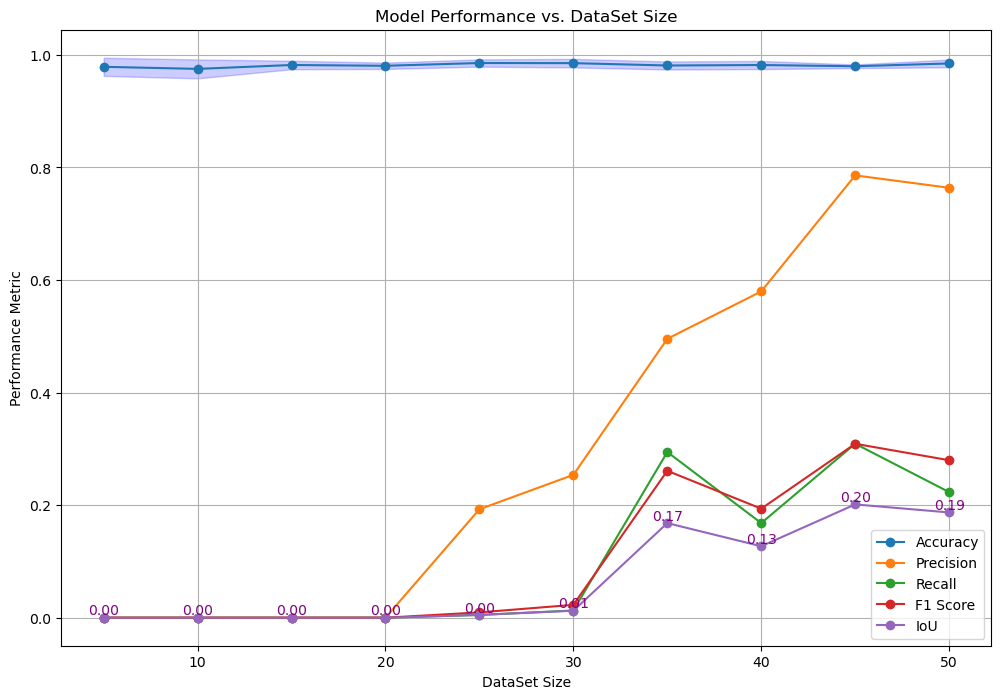

In [36]:
plt.figure(figsize=(12, 8))

# 畫出每個指標
# plt.errorbar(train_sizes, mean_accuracies, yerr=std_accuracies, label='Accuracy', fmt='-o', capsize=5)
plt.fill_between(train_sizes, 
                 np.array(mean_accuracies) - np.array(std_accuracies), 
                 np.array(mean_accuracies) + np.array(std_accuracies), 
                 color='blue', alpha=0.2)
plt.plot(train_sizes, mean_accuracies, label='Accuracy', marker='o')
plt.errorbar(train_sizes, mean_precisions, label='Precision', fmt='-o', capsize=5)
plt.errorbar(train_sizes, mean_recalls, label='Recall', fmt='-o', capsize=5)
plt.errorbar(train_sizes, mean_f1_scores, label='F1 Score', fmt='-o', capsize=5)
plt.errorbar(train_sizes, mean_ious, label='IoU', fmt='-o', capsize=5)
for i, txt in enumerate(mean_ious):
    plt.text(train_sizes[i], mean_ious[i], f'{txt:.2f}', ha='center', va='bottom', color='purple')

plt.title('Model Performance vs. DataSet Size')
plt.xlabel('DataSet Size')
plt.ylabel('Performance Metric')
plt.legend()
plt.grid(True)
plt.show()


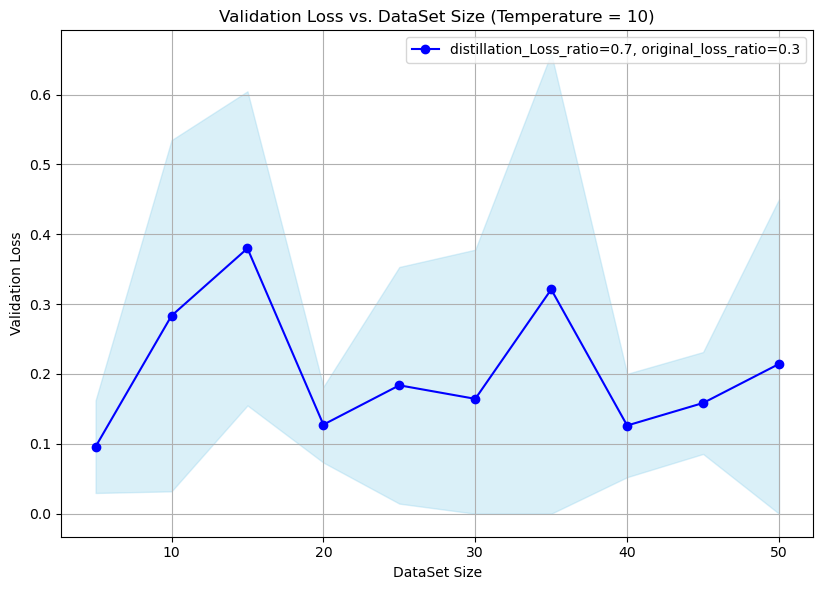

In [35]:
plt.figure(figsize=(16, 6))

# 圖1
plt.subplot(1, 2, 1)
plt.plot(train_sizes, mean_val_losses_KD, marker='o', color='b', label=f'distillation_Loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 1)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses_KD) - np.array(std_val_losses_KD)), 
                 np.array(mean_val_losses_KD) + np.array(std_val_losses_KD), color='skyblue', alpha=0.3)
plt.title(f'Validation Loss vs. DataSet Size (Temperature = {temperature})')
plt.xlabel('DataSet Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()
"""
# 圖2
plt.subplot(1, 2, 2)
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label='distillation_Loss_ratio=0, original_loss_ratio=1')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title(f'Validation Loss vs. DataSet Size (temperature = {temperature})')
plt.xlabel('DataSet Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.legend()
"""
plt.tight_layout()  # 避免重疊
plt.show()


印出來看看👀


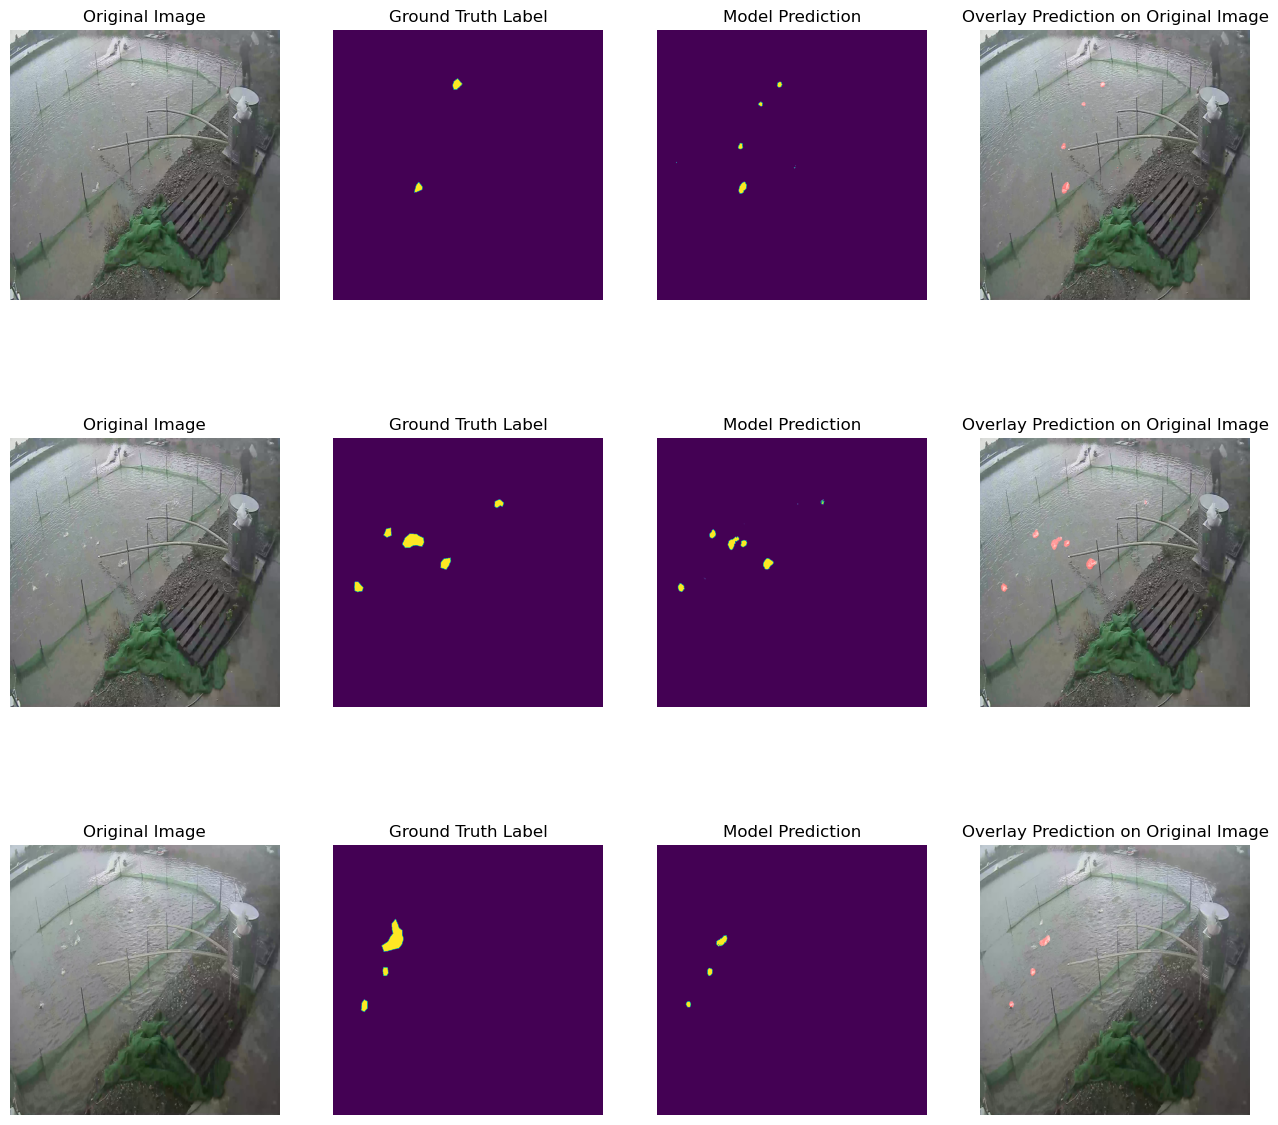

outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
tensor([[[[  1.3108,   1.3108,   1.3608,  ...,   0.7551,   0.6571,   0.6571],
          [  1.3108,   1.3108,   1.3608,  ...,   0.7551,   0.6571,   0.6571],
          [  1.2528,   1.2528,   1.3183,  ...,   0.8099,   0.7287,   0.7287],
          ...,
          [  0.9557,   0.9557,   0.8556,  ...,   1.5958,   1.6847,   1.6847],
          [  1.0669,   1.0669,   0.9561,  ...,   1.7304,   1.8236,   1.8236],
          [  1.0669,   1.0669,   0.9561,  ...,   1.7304,   1.8236,   1.8236]],

         [[-47.9012, -47.9012, -47.8457,  ..., -37.0101, -37.3793, -37.3793],
          [-47.9012, -47.9012, -47.8457,  ..., -37.0101, -37.3793, -37.3793],
          [-48.7112, -48.7112, -48.6241,  ..., -36.9946, -37.3400, -37.3400],
          ...,
          [-41.4456, -41.4456, -40.5657,  ..., -35.7145, -36.4086, -36.4086],
          [-41.4938, -41.4938, -40.6380,  ..., -36.4049, -37.1275, -37.1275],
          [-41.4938, -41.4938, -40.6380,  ..., -36.4049,

In [28]:
print("印出來看看👀")
showSegmentationResult(segformer_model, val_dataset, num_images=3)

### 以下備用 🤗

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def cal_iou(model, dataset, num_images=10):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    total_iou = 0.0

    for i, idx in enumerate(range(min(len(dataset), num_images))):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))   
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Compute IoU
        prediction_mask = (labels == 1)
        target_mask = (target.squeeze() == 1).numpy()  # Assuming your ground truth is also a binary mask

        metrics = compute_metrics(prediction_mask, target_mask)
        print(metrics)
        intersection = np.logical_and(target_mask, prediction_mask)
        union = np.logical_or(target_mask, prediction_mask)
        iou = intersection.sum() / union.sum()
        total_iou += iou

    average_iou = total_iou / num_images
    print(f"Average IoU over {num_images} images: {average_iou}")

    return average_iou

def compute_metrics(prediction, ground_truth, calculate_accuracy=True, calculate_precision=True, calculate_recall=True, calculate_f1=True):
    """
    Compute performance metrics for binary classification.

    :param prediction: Predicted binary mask
    :param ground_truth: Ground truth binary mask
    :param calculate_accuracy: Whether to calculate accuracy
    :param calculate_precision: Whether to calculate precision
    :param calculate_recall: Whether to calculate recall
    :param calculate_f1: Whether to calculate F1 score
    :return: Dictionary with requested metrics
    """
    TP, FP, TN, FN = calculate_confusion_matrix_elements(prediction, ground_truth)

    metrics = {}

    if calculate_accuracy:
        metrics['accuracy'] = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    if calculate_precision:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        metrics['precision'] = precision

    if calculate_recall:
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['recall'] = recall

    if calculate_f1:
        if 'precision' not in metrics:
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        if 'recall' not in metrics:
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        metrics['f1_score'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return metrics

def calculate_confusion_matrix_elements(prediction, ground_truth):
    TP = np.sum((prediction == 1) & (ground_truth == 1))
    FP = np.sum((prediction == 1) & (ground_truth == 0))
    TN = np.sum((prediction == 0) & (ground_truth == 0))
    FN = np.sum((prediction == 0) & (ground_truth == 1))

    return TP, FP, TN, FN


cal_iou(segformer_model, val_dataset)

{'accuracy': 0.9698925018310547, 'precision': 0.7188302801853497, 'recall': 0.6012168919054599, 'f1_score': 0.6547840349917987}
{'accuracy': 0.9919242858886719, 'precision': 0.971334431630972, 'recall': 0.41550387596899224, 'f1_score': 0.5820335636722607}
{'accuracy': 0.9791412353515625, 'precision': 0.9132903343023255, 'recall': 0.6901558316743324, 'f1_score': 0.7861974584555229}
{'accuracy': 0.9931621551513672, 'precision': 1.0, 'recall': 0.22712083647730946, 'f1_score': 0.3701686577652846}
{'accuracy': 0.9963216781616211, 'precision': 0.8620904836193448, 'recall': 0.4472321139527355, 'f1_score': 0.5889374400511563}
{'accuracy': 0.9796638488769531, 'precision': 0.9664925494007127, 'recall': 0.7082010503516007, 'f1_score': 0.8174283806229558}
{'accuracy': 0.9978694915771484, 'precision': 0, 'recall': 0.0, 'f1_score': 0}
{'accuracy': 0.9959430694580078, 'precision': 1.0, 'recall': 0.00211118930330753, 'f1_score': 0.0042134831460674165}
{'accuracy': 0.9893627166748047, 'precision': 0.91

0.38217996037079954

In [16]:
import numpy as np
import torch

def evaluate_metrics(model, dataset):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    total_metrics = {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'iou': 0.0}
    num_images = len(dataset)

    for idx in range(num_images):
        image, target = dataset[idx]
        outputs = model(torch.unsqueeze(image, 0).to(device))
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        prediction_mask = (labels == 1)
        target_mask = (target.squeeze() == 1).numpy()  # Assuming your ground truth is also a binary mask

        metrics = compute_metrics(prediction_mask, target_mask)
        intersection = np.logical_and(target_mask, prediction_mask)
        union = np.logical_or(target_mask, prediction_mask)
        iou = intersection.sum() / union.sum()

        for key in total_metrics.keys():
            if key in metrics:
                total_metrics[key] += metrics[key]
        total_metrics['iou'] += iou

    # Calculate average of each metric
    for key in total_metrics.keys():
        total_metrics[key] /= num_images

    print(f"Average metrics over {num_images} images: {total_metrics}")

    return total_metrics

# Assuming you have segformer_model and val_dataset defined
evaluate_metrics(segformer_model, val_dataset)


Average metrics over 10 images: {'accuracy': 0.9883174896240234, 'precision': 0.8312998709592152, 'recall': 0.4080578652007908, 'f1_score': 0.5020132248956176, 'iou': 0.38217996037079954}


{'accuracy': 0.9883174896240234,
 'precision': 0.8312998709592152,
 'recall': 0.4080578652007908,
 'f1_score': 0.5020132248956176,
 'iou': 0.38217996037079954}